# This notebook is dedicated to performing various benchmarks of CCA from CCA_calc.py
See more info about it [here](https://www.draw.io/#G0BxWRyyRCfA3gb1ViSTVuWDRuR0U) and on [github](https://github.com/artefom/prrn-mosaic)

In [283]:
%pylab inline
import pandas as pd
import re
import os
from matplotlib.ticker import MaxNLocator
from scipy.interpolate import spline
from sklearn.cross_decomposition import CCA
import sklearn.cross_decomposition

def interpolate(x,y):
    """
    used for smooth graph output
    """
    x_smooth = np.linspace(x.min(),x.max(),300) #300 represents number of points to make between T.min and T.max
    y_smooth = spline(x,y,x_smooth)
    return x_smooth,y_smooth

def gen_test_gmd(n_samples,n_bands):
    """
    returns console program for line-by-line benchmark of python script
    """
    return 'kernprof -v -l CCA_calc_test.py {} {}'.format(n_samples,n_bands)

def run_tests(n_samples,n_bands):
    """
    run CCA_calc_tesy.py preformance profile tests. returns output as a plain text
    """
    text = os.popen(gen_test_gmd(n_samples,n_bands)).read()
    
    return text

# What lines should we record from the profile plain text output
record_lines = {
    'calc_covariance' : ['calc_.._cov\(.*\)([^:]|\Z)'],
    'push' : ['push\(.*\)([^:]|\Z)'],
    'calc_ab' : ['calc_ab\(.*\)([^:]|\Z)'],
}

# Parse profiler output into dictionary
def parse_test_results(text):

    lines = text.split('\n')

    ret = dict()
    for k,v in record_lines.items():
        ret[k] = []
    
    time_unit = float(re.findall('Timer\sunit:\s([^\n]+)\s+s',text)[0])
    columns = ['Line #','Hits','Time','Per Hit','% Time']
    time_per_hit_column = columns.index('Per Hit')
    
    for line in lines:
        for k,v in record_lines.items():
            for pattern in v:
                if len( re.findall(pattern,line) ) > 0:
                    values = np.array([float(i) for i in line.split()[:len(columns)]])
                    ret[k].append(values[time_per_hit_column]*time_unit)
                    
    for k in ret.keys():
        ret[k] = np.min(ret[k])
        
        
    correlation = float(re.findall('correlation:\s([^\n]+)',text)[0])
    
    ret['cor'] = correlation
    
    return ret

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.5/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [279]:
# the same as above but a bit faster, though, without line-by-line execution times

import importlib
import CCA_calc
importlib.reload(CCA_calc)
import time
from collections import defaultdict

def gen_samples(sample_size,n_bands=3):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    Y = X+np.random.normal(0,0.5,size=(sample_size,n_bands))
    return X,Y


sk_cca = sklearn.cross_decomposition.CCA(n_components=1)
def run_test_fast(n_samples,n_bands,calc_precision=False):
    cca =  CCA_calc.CCA(n_bands)

    results = defaultdict(list)
    
    for i in range(10):
        X,Y = gen_samples(n_samples,n_bands)
        
        
        t_before = time.perf_counter()
        cca.push(X,Y)
        t_after = time.perf_counter()
        results['push time'].append(t_after-t_before)
        
        t_before = time.perf_counter()
        ab = cca.calc_ab_adv(dont_use_ab=False)
        t_after = time.perf_counter()
        results['grad time'].append(t_after-t_before)
        
        results['total'].append( results['push time'][-1] + results['grad time'][-1] )
        
        if calc_precision:
            a = ab[:int(ab.size/2)]
            b = ab[int(ab.size/2):]
            corr_got = np.corrcoef( np.dot(X,np.ravel(a)), np.dot(Y,np.ravel(b)) )[0,1]
            sk_cca.fit(X,Y)
            X_new,Y_new = sk_cca.transform(X,Y)
            corr_true = np.corrcoef(np.ravel(X_new),np.ravel(Y_new),rowvar=False)[0,1]
            results['precision'].append(precision)

        
    for k,v in results.items():
        results[k] = np.mean(v)
    
    return results

# Performance benchmarks

In [280]:
# some caching
cache = dict()

def run_test(*args,fast=True):
    if fast:
        return run_test_fast(*args)
    else:
        text = '###\n'.join( [run_tests(*args) for i in range(2)] )
        results = parse_test_results(text)
        
def run_test_cached(*args):
    if args in cache:
        return cache[args]
    ret = run_test(*args)
    cache[args]=ret
    return ret

In [281]:
# results of profile CCA_calc.py

from collections import defaultdict

n_samples = (np.logspace(1,10,base=1.5,num=20)*5000).astype(np.int)
n_bands = np.array([2,8,12])

band_profile_n_samples = np.array( [100*100,50*50] )
band_profile_n_bands = np.array([2,4,6,8,12,14,18,20,22,24,26,28,30])#np.arange(2,13)

measures = defaultdict(lambda: defaultdict(list))
band_measures = defaultdict(lambda: defaultdict(list))

progress_max = len(n_samples)*len(n_bands)
for i,n in enumerate(n_samples):
    for j,n_b in enumerate(n_bands):
        progress = i*len(n_bands)+j+1
        if progress % 10 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_cached(n,n_b)
        for k,v in results.items():
            measures[n_b][k].append(v)
         
        
progress_max = len(band_profile_n_samples)*len(band_profile_n_bands)
for i,n in enumerate(band_profile_n_samples):
    for j,n_b in enumerate(band_profile_n_bands):
        progress = (i*len(band_profile_n_bands))+j+1
        if progress % 5 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_cached(n,n_b)
        for k,v in results.items():
            try:
                band_measures[n][k].append(v)
            except KeyError:
                band_measures[n] = band_measures.get(n,dict())
                band_measures[n][k] = []
        
for k,v in measures.items():
    for k2,v2 in v.items():
        measures[k][k2] = np.array(measures[k][k2])
        
for k,v in band_measures.items():
    for k2,v2 in v.items():
        band_measures[k][k2] = np.array(band_measures[k][k2])

running test for 7500 samples and 2 bands (1 of 60)
running test for 13344 samples and 8 bands (11 of 60)
running test for 23742 samples and 12 bands (21 of 60)
running test for 51189 samples and 2 bands (31 of 60)
running test for 91077 samples and 8 bands (41 of 60)
running test for 162049 samples and 12 bands (51 of 60)
running test for 288325 samples and 12 bands (60 of 60)
running test for 10000 samples and 2 bands (1 of 26)
running test for 10000 samples and 14 bands (6 of 26)
running test for 10000 samples and 26 bands (11 of 26)
running test for 2500 samples and 6 bands (16 of 26)
running test for 2500 samples and 20 bands (21 of 26)
running test for 2500 samples and 30 bands (26 of 26)


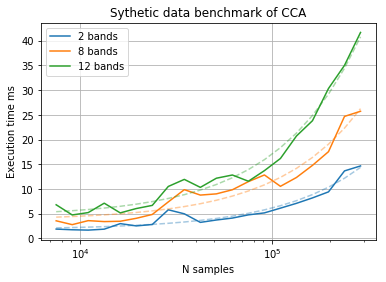

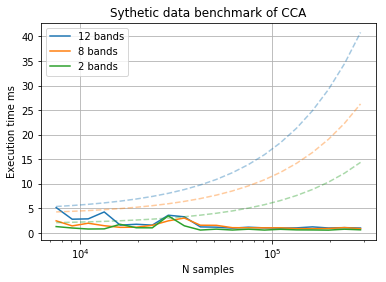

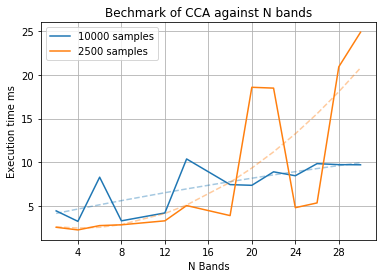

In [282]:
from sklearn import linear_model

clfs = dict()

# Plot total execution time
for i,band in enumerate( n_bands ):
    
    color = 'C{}'.format(i)
    label = '{} bands'.format(band) if band > 1 else '1 band'
    #plot(n_samples,measures['calc_covariance']*1e3,label='covariance');
    
    plot(n_samples,measures[band]['total']*1e3,'{}'.format(color),label=label);
#     plot(n_samples,measures[band]['precision'],color,label=label)

    # plot fitting line
    clf = linear_model.Ridge()
    clf.fit(n_samples[:,np.newaxis],measures[band]['total']*1e6)
    plot(n_samples,clf.predict(n_samples[:,np.newaxis])/1e3,'{}--'.format(color),alpha=0.4 );
    clfs[band] = clf
    
grid(True)
title('Sythetic data benchmark of CCA')
xscale('log')
ylabel('Execution time ms')
xlabel('N samples')
legend()
show()

# Plot execution time of gradient against total time
for i,band in enumerate( n_bands[::-1] ):
    
    color = 'C{}'.format(i)
    label = '{} bands'.format(band) if band > 1 else '1 band'
    #plot(n_samples,measures['calc_covariance']*1e3,label='covariance');
    
    plot(n_samples,measures[band]['grad time']*1e3,'{}'.format(color),label=label);
#     plot(n_samples,measures[band]['precision'],color,label=label)

    # plot fitting line
    clf = linear_model.Ridge()
    clf.fit(n_samples[:,np.newaxis],measures[band]['total']*1e6)
    plot(n_samples,clf.predict(n_samples[:,np.newaxis])/1e3,'{}--'.format(color),alpha=0.4 );
    clfs[band] = clf
    
grid(True)
title('Sythetic data benchmark of CCA')
xscale('log')
ylabel('Execution time ms')
xlabel('N samples')
legend()
show()

## PLOT CALCULATION PRECISION
try:
    for i,band in enumerate( n_bands ):
        color = 'C{}'.format(i)
        label = '{} bands'.format(band) if band > 1 else '1 band'
        plot(n_samples,measures[band]['precision'],color,label=label,alpha=0.9)

    grid(True)
    legend()
    title('Calculation precision')
    ylabel('p_optimal - p_got')
    xlabel('N Samples')
    show()
except Exception as ex:
    pass

for i,n in enumerate( band_profile_n_samples ):
    
    color = 'C{}'.format(i)
    label = '{} samples'.format(n)
    
    plot(band_profile_n_bands,band_measures[n]['total']*1e3,color,label=label);
    
    
    clf = linear_model.Ridge()
    
    bands_x = band_profile_n_bands[:,np.newaxis]
    new_x = np.concatenate((bands_x,bands_x*bands_x),axis=1)
    clf.fit(new_x,band_measures[n]['total']*1e6)
    plot(band_profile_n_bands,clf.predict(new_x)/1e3,'{}--'.format(color),alpha=0.4 );

    
#ax = plt.figure().gca()
axes().xaxis.set_major_locator(MaxNLocator(integer=True))
grid(True)
legend()
title('Bechmark of CCA against N bands')
ylabel('Execution time ms')
xlabel('N Bands')
show();
        
#print('T(N) = {:.3f} + {:.0f} N [ns]'.format(clf.coef_[0],clf.intercept_))
#plot(n_samples,measures['calc_ab']*1e3,label='a,b');

# Bechmark of sklearn

In [363]:
sk_cache = dict()

In [364]:
from sklearn.cross_decomposition import CCA

def run_tests_sk(n,n_b):
    cca =  CCA(n_components=1)

    results = defaultdict(list)
    
    for i in range(10):
        X,Y = gen_samples(n,n_b)
        
        t_before = time.perf_counter()
        cca.fit(X,Y)
        t_after = time.perf_counter()
        results['total'].append(t_after-t_before)
    
    for k,v in results.items():
        results[k] = np.mean(v)
    
    return results

def run_test_sk_cached(n,n_b):
    if (n,n_b) in sk_cache:
        return sk_cache[(n,n_b)]
    return run_tests_sk(n,n_b)

sk_n_samples = (np.logspace(1,10,base=1.5,num=20)*1000).astype(np.int)
sk_n_bands = np.array([8])
sk_measures = defaultdict(lambda: defaultdict(list))

progress_max = len(sk_n_samples)*len(sk_n_bands)
for i,n in enumerate(sk_n_samples):
    for j,n_b in enumerate(sk_n_bands):
        progress = i*len(sk_n_bands)+j+1
        if progress % 10 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_sk_cached(n,n_b)
        for k,v in results.items():
            sk_measures[n_b][k].append(v)

running test for 1500 samples and 8 bands (1 of 20)


/usr/local/lib/python3.5/dist-packages/sklearn/cross_decomposition/pls_.py:83: UserWarning: Maximum number of iterations reached
  warnings.warn('Maximum number of iterations reached')


running test for 10237 samples and 8 bands (11 of 20)
running test for 57665 samples and 8 bands (20 of 20)


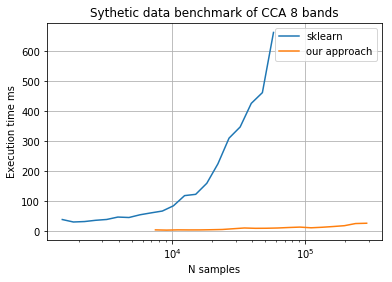

In [365]:
plot( sk_n_samples, np.array(sk_measures[8]['total'])*1000, label='sklearn')
plot( n_samples, measures[8]['total']*1000, label='our approach' )
grid(True)
title('Sythetic data benchmark of CCA 8 bands')
xscale('log')
ylabel('Execution time ms')
xlabel('N samples')
legend()
show()

In [ ]:
from sklearn.cross_decomposition
def run_tests_sk(n,n_b):
    cca =  CCA_calc.CCA(n_bands)

    results = defaultdict(list)
    
    for i in range(10):
        X,Y = gen_samples(n_samples,n_bands)
        
        
        t_before = time.perf_counter()
        cca.push(X,Y)
        t_after = time.perf_counter()
        results['push time'].append(t_after-t_before)
        
        t_before = time.perf_counter()
        ab = cca.calc_ab_adv(dont_use_ab=False)
        t_after = time.perf_counter()
        results['grad time'].append(t_after-t_before)
        
        results['total'].append( results['push time'][-1] + results['grad time'][-1] )
        
        if calc_precision:
            a = ab[:int(ab.size/2)]
            b = ab[int(ab.size/2):]
            corr_got = np.corrcoef( np.dot(X,np.ravel(a)), np.dot(Y,np.ravel(b)) )[0,1]
            sk_cca.fit(X,Y)
            X_new,Y_new = sk_cca.transform(X,Y)
            corr_true = np.corrcoef(np.ravel(X_new),np.ravel(Y_new),rowvar=False)[0,1]
            results['precision'].append(precision)

        
    for k,v in results.items():
        results[k] = np.mean(v)
    
    return results

sk_cache = dict()
def run_test_sk_cached(n,n_b):
    if (n,n_b) in sk_cache:
        return sk_cache[(n,n_b)]
    run_tests_sk(n,n_b)

sk_n_samples = (np.logspace(1,10,base=1.5,num=20)*5000).astype(np.int)
sk_n_bands = np.array([12])
sk_measures = defaultdict(lambda: defaultdict(list))

progress_max = len(sk_n_samples)*len(sk_n_bands)
for i,n in enumerate(sk_n_samples):
    for j,n_b in enumerate(sk_n_bands):
        progress = i*len(sk_n_bands)+j+1
        if progress % 10 == 1 or progress == progress_max:
            print('running test for {} samples and {} bands ({} of {})'.format(n,n_b,progress,progress_max))
        results = run_test_cached(n,n_b)
        for k,v in results.items():
            measures[n_b][k].append(v)

# Test when input data is correlated

In [185]:
def gen_samples(sample_size,n_bands=3,band_correlation=0.4):
    X = np.random.normal(0,1,size=(sample_size,n_bands))
    X[:,2:] = X[:,2:]+np.random.normal(0,1-band_correlation,size=(sample_size,n_bands-2))
    Y = X+np.random.normal(0,1,size=(sample_size,n_bands))
    return X*1000,Y*1000

x,y = gen_samples(1000,n_bands=12,band_correlation=0.99)

cca = CCA_calc.CCA(12)
cca.push(x,y)
print('my  :',cca.calc_correlation())

cca_sk = CCA(n_components=1)
cca_sk.fit(x,y)
x_new,y_new = cca_sk.transform(x,y)
print('real:',np.corrcoef(x_new,y_new,rowvar=False)[0,1])

my  : 0.701876349951
real: 0.766400722766


## Estimated calculation time for different size images

In [408]:
def print_calc_time(x_size,y_size,postfix=''):
    megapixels = x_size*y_size/1e6
    n_bands = 8
    print('{: >6} x{: >6} {} bands ({: >6.2f} MPix): {:.0f} ms {}'.format(x_size,y_size,n_bands,megapixels,clfs[n_bands].predict([[x_size*y_size]])[0]/1e3,postfix))
    
print_calc_time(1024,1024)
print_calc_time(4000,4000)
print_calc_time(6100,6100,'(Landsat 8)')
print_calc_time(12000,12000)

  1024 x  1024 8 bands (  1.05 MPix): 95 ms 
  4000 x  4000 8 bands ( 16.00 MPix): 1432 ms 
  6100 x  6100 8 bands ( 37.21 MPix): 3328 ms (Landsat 8)
 12000 x 12000 8 bands (144.00 MPix): 12877 ms 


# Tests on real data

In [3]:
# load list of test samples
import csv
import numpy as np
with open('test_files_aligned.csv','r') as f:
    reader = csv.reader(f.readlines())
    test_files = [i for i in reader]
    # remove header
    test_files = test_files[1:]
    
# class for generating 2 random samples

import gdal
import gdalio
class Test_generator:
    """
    Simple class for generating test samples.
    """
    def __init__(self,files,shuffle=True):
        """
        files - 2-d iterable containing pairs of string values. each string value is path to file.
        """
        self.files = [(f1,f2) for f1,f2 in files]
        if shuffle:
            self.shuffle()
        self.current_sample = 0

        
    def generator(self,n_samples=None,shuffle=True):
        if n_samples is None:
            n_samples = len(self.files)
        if shuffle:
            self.shuffle()
        for i in range(n_samples):
            yield self.get_sample(i)
        
    def shuffle(self):
        np.random.shuffle(self.files)
        
    def get_sample(self,samp_id=None,image_only=False):
        
        # get next sample id if necessary
        if samp_id is None:
            samp_id = get_sample_id(self)
        f1,f2 = self.files[samp_id]
        
        ds1 = gdal.Open(f1)
        ds2 = gdal.Open(f2)
        
        if image_only:
            return gdalio.readAsArray(ds1),gdalio.readAsArray(ds2)
        return ds1,ds2
    
    def get_sample_id(self):
        """
        get id of current sample, increase counter and loop back if necessary.
        Internal function
        """
        ret = self.current_sample
        self.current_sample+=1
        if self.current_sample >= len(self.files):
            self.current_sample = 0
        return ret

    
testgen = Test_generator(test_files)

In [4]:
for ds1,ds2 in testgen.generator(1):
    im1,im2 = gdalio.readAsArray(ds1), gdalio.readAsArray(ds2)

In [5]:
import CCA_calc

cca = CCA_calc.CCA(12)
cca.push(im1.reshape((-1,12)),im2.reshape((-1,12)))

In [7]:
cca.calc_correlation()

0.45595298463048822

In [8]:
from sklearn.cross_decomposition import CCA

In [9]:
cca_sk = CCA(n_components=1)
cca_sk.fit(im1.reshape((-1,12)),im2.reshape((-1,12)))

CCA(copy=True, max_iter=500, n_components=1, scale=True, tol=1e-06)

In [10]:
X_new,Y_new = cca_sk.transform(im1.reshape((-1,12)),im2.reshape((-1,12)))

In [11]:
print('correlation coef:',np.corrcoef(np.ravel(X_new),np.ravel(Y_new))[0,1])

correlation coef: 0.743860459426


In [12]:
im1_2 = np.array( im1 )
im1_2 = (im1_2 - im1_2.mean(axis=(0,1)))/im1_2.std(axis=(0,1))
im2_2 = np.array( im2 )
im2_2 = (im2_2 - im2_2.mean(axis=(0,1)))/im2_2.std(axis=(0,1))

In [13]:
cca2 = CCA_calc.CCA(12)
cca2.push(im1_2.reshape((-1,12)),im2_2.reshape((-1,12)))
cca2.calc_correlation()

0.45673120089951164

In [189]:
np.__file__

'/usr/local/lib/python3.5/dist-packages/numpy/__init__.py'

In [247]:
import importlib
from collections import defaultdict
importlib.reload(CCA_calc)

x = np.array( im1_2.reshape((-1,12)) )
y = np.array( im2_2.reshape((-1,12)) )

x = (x - x.mean(axis=(0,1)))/x.std(axis=(0,1))
y = (y - y.mean(axis=(0,1)))/y.std(axis=(0,1))

#np.random.shuffle(x)
#np.random.shuffle(y)

test_results = defaultdict(list)

for n_samples in np.linspace(100,100000,50):
    n_samples = int(n_samples)
    print('running for {} samples'.format(n_samples))
    cca2 = CCA_calc.CCA(12)
    cca2.push(x[:n_samples],y[:n_samples])
    my_cor_legacy = cca2.correlation( cca2.calc_ab() )[0,0]
    my_cor_no_ab = cca2.correlation( cca2.calc_ab_adv(dont_use_ab=True) )
    my_cor_ab = cca2.correlation( cca2.calc_ab_adv(dont_use_ab=False) )
    #a,b = cca2.calc_ab()

    #x_my = np.ravel( np.dot(x[:n_samples],a) )
    #y_my = np.ravel( np.dot(y[:n_samples],b) )

    
    cca_sk2 = CCA(n_components=1)
    cca_sk2.fit(x[:n_samples],y[:n_samples])
    x_sk,y_sk = cca_sk2.transform(x[:n_samples],y[:n_samples])

    x_sk = np.ravel(x_sk)
    y_sk = np.ravel(y_sk)
    sk_cor = np.corrcoef(x_sk,y_sk)[0,1]
    
    test_results['grad optimization'].append(my_cor_no_ab)
    test_results['wiki solution'].append(my_cor_legacy)
    test_results['wiki + grad opt'].append(my_cor_ab)
    test_results['sklearn'].append(sk_cor)
    test_results['n_samples'].append(n_samples)

running for 100 samples
running for 2138 samples
running for 4177 samples
running for 6216 samples
running for 8255 samples
running for 10293 samples
running for 12332 samples
running for 14371 samples
running for 16410 samples
running for 18448 samples
running for 20487 samples
running for 22526 samples
running for 24565 samples
running for 26604 samples
running for 28642 samples
running for 30681 samples
running for 32720 samples
running for 34759 samples
running for 36797 samples
running for 38836 samples
running for 40875 samples
running for 42914 samples
running for 44953 samples
running for 46991 samples
running for 49030 samples
running for 51069 samples
running for 53108 samples
running for 55146 samples
running for 57185 samples
running for 59224 samples
running for 61263 samples
running for 63302 samples
running for 65340 samples
running for 67379 samples
running for 69418 samples
running for 71457 samples
running for 73495 samples
running for 75534 samples
running for 77573 

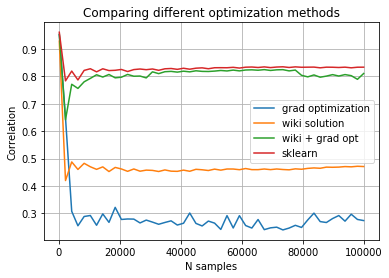

In [250]:
grid(True)
title("Comparing different optimization methods")
xlabel('N samples')
ylabel('Correlation')
y_value = 'n_samples'
for k in test_results:
    if k != y_value:
        plot( test_results[y_value],test_results[k],label=k)
legend()

# Create input for Java application

In [303]:
import csv

with open('./OLD/test_files.csv') as f:
    reader = csv.reader(f.readlines())
    files = set()

    # skip header
    next(reader)
    for f1,f2,d in reader:
        files.add(f1)
        files.add(f2)

In [305]:
len(files)

288

In [308]:
with open('mosaic_files.txt','w') as f:
    for mosaic_path in files:
        f.write('{}\n'.format(mosaic_path))

In [309]:
    def roundAway(x):
        """
        Simulates Python 2 round behavour
        This is what we want as it rounds away from 0.
        The decimal module seems to be the only way to do this properly
        """
        import decimal
        dec = decimal.Decimal(x).quantize(decimal.Decimal('1'), 
                rounding=decimal.ROUND_HALF_UP)
        return float(dec.to_integral_value())

In [327]:
def roundaway2(x):
    if x < 0:
        return round(0.5)
    else:
        return round(x)
    
def pt(x):
    a = roundAway(x)
    b = roundaway2(x)
    print('{: <8} {} -> {: <8}, {: <8}'.format(x,a==b,a,b))
    
pt(-1.5111)
pt(-1.5)
pt(-1.4999)

pt(-0.5111)
pt(-0.5)
pt(-0.4999)

pt(.5111)
pt(.5)
pt(.4999)

pt(1.5111)
pt(1.5)
pt(1.4999)

del pt

-1.5111  False -> -2.0    , 0       
-1.5     False -> -2.0    , 0       
-1.4999  False -> -1.0    , 0       
-0.5111  False -> -1.0    , 0       
-0.5     False -> -1.0    , 0       
-0.4999  True -> -0.0    , 0       
0.5111   True -> 1.0     , 1       
0.5      False -> 1.0     , 0       
0.4999   True -> 0.0     , 0       
1.5111   True -> 2.0     , 2       
1.5      True -> 2.0     , 2       
1.4999   True -> 1.0     , 1       
